In [73]:
import pandas as pd
import numpy as np
import sklearn
import json
import matplotlib.pyplot as plot
%matplotlib inline

In [2]:
info_file = 'user_metadata_latest.jsonl'
info_train = []
with open(info_file) as fp:
    for line in fp.readlines():
        info_train.append(json.loads(line))

In [3]:
user_info = pd.DataFrame(info_train)

In [56]:
user_info.head()

,created_at,description,favourites_count,followers_count,friends_count,id,lang,listed_count,location,name,profile_location,screen_name,statuses_count,time_zone,utc_offset,verified
0,2018-03-25 02:13:52,eating disorder survivor - cat lover - writer ...,27,57,154,977730252649705472,en,0,,Jeanine Cyze,None,cyzeoversize,82,None,None,False
1,2016-06-11 17:44:25,Mental health + Autism campaigner in Wales. Ra...,2332,949,696,741687543687741440,en,6,"Wales, United Kingdom",Mair Elliott,None,MairElliott1,1835,None,None,False
2,2011-07-19 04:34:11,Sometimes I paint my pictures with words. Some...,3785,250,521,338151808,en,6,The Mitten ✋🏻,Kala✨,None,ItsKalaNoY,16916,None,None,False
3,2009-05-17 16:36:28,♡ 22 year old Princess from Scotland. ✨ Tattoo...,22307,2867,517,40688348,en,25,Wonderland,🖤👻 Ree 🎃🖤,None,earthtoree,53628,None,None,False
4,2009-09-23 10:06:57,..Change is always possible.. Trying to recove...,639,801,869,76607387,en,20,,Beck,None,NewFoundWings,18537,None,None,False


In [5]:
dump = user_info[['description','statuses_count', 'screen_name']]

In [6]:
dump

,description,statuses_count,screen_name
0,eating disorder survivor - cat lover - writer ...,82,cyzeoversize
1,Mental health + Autism campaigner in Wales. Ra...,1835,MairElliott1
2,Sometimes I paint my pictures with words. Some...,16916,ItsKalaNoY
3,♡ 22 year old Princess from Scotland. ✨ Tattoo...,53628,earthtoree
4,..Change is always possible.. Trying to recove...,18537,NewFoundWings
5,sensitive gal de profession #queerasfuck #meto...,573,lilglacevanille
6,"Runner, warrior, author of Stand Tall Little G...",24640,HopeVirgo
7,Lisabeth's story is one of wrestling with her ...,240,lisabethkaeser
8,21|VanCity|Music|Swiftie|Youtube = life. I MET...,2303,AmandaGrundle
9,coffee drinking tree hugger 🌲 🏕 PTA student. r...,5978,HanBaNannz


In [7]:
tweet_file = 'user_tweets_latest.jsonl'
tweet_train = []
with open(tweet_file) as fp:
    for line in fp.readlines():
        tweet_train.append(json.loads(line))

In [8]:
tweets = pd.DataFrame(tweet_train)

In [9]:
tweets.head()

,entities,id,in_reply_to_status_id,in_reply_to_user_id,text,truncated,tweeter_id,tweeter_screen_name
0,"{'hashtags': [], 'symbols': [], 'user_mentions...",1050256335491616768,1.050256e+18,573318461.0,Oh and btw I met her in your unicorn onesie an...,False,573318461,AmandaGrundle
1,"{'hashtags': [{'text': 'anorexiarecovery', 'in...",1050256080029118465,NaN,NaN,Hey @laurDIY!! Just me over here reminiscing o...,False,573318461,AmandaGrundle
2,"{'hashtags': [], 'symbols': [], 'user_mentions...",1049484781400936448,1.049175e+18,338597571.0,@joeygrundl Omg lucky,False,573318461,AmandaGrundle
3,"{'hashtags': [], 'symbols': [], 'user_mentions...",1049402347808534529,NaN,NaN,I added a video to a @YouTube playlist https:/...,False,573318461,AmandaGrundle
4,"{'hashtags': [], 'symbols': [], 'user_mentions...",1049376542562836480,NaN,NaN,VOTED!!! I’M SO EXCITED TO SEE @taylorswift13 ...,False,573318461,AmandaGrundle


In [10]:
NewFoundWings = tweets[tweets.tweeter_screen_name=='NewFoundWings']

In [11]:
NewFoundWings.reset_index(inplace=True)

In [13]:
NewFoundWings.head()

,index,entities,id,in_reply_to_status_id,in_reply_to_user_id,text,truncated,tweeter_id,tweeter_screen_name
0,10494,"{'hashtags': [], 'symbols': [], 'user_mentions...",1051741357876883457,1.051734e+18,20902901.0,@BefuddledSharon I know some schools already d...,False,76607387,NewFoundWings
1,10495,"{'hashtags': [{'text': 'Casualty', 'indices': ...",1051466061407772684,1.051405e+18,706876069.0,@BBCCasualty People questioning how she got to...,False,76607387,NewFoundWings
2,10496,"{'hashtags': [], 'symbols': [], 'user_mentions...",1051461255796576256,1.051458e+18,44356998.0,@RoyalParksHalf @Pret @Luciee_lu We missed thi...,False,76607387,NewFoundWings
3,10497,"{'hashtags': [{'text': 'BBCSML', 'indices': [2...",1051429683278024706,NaN,NaN,Mental health - everyone has it.\n\nMental ill...,False,76607387,NewFoundWings
4,10498,"{'hashtags': [{'text': 'BBCSML', 'indices': [2...",1051428577818886144,NaN,NaN,'The best people to see mental health issues a...,False,76607387,NewFoundWings


In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from imp import reload
import TweetPreprocessor
reload(TweetPreprocessor)
from TweetPreprocessor import TweetPreprocessor 

analyser = SentimentIntensityAnalyzer()

def analyse_sentiment(tweeter, preprocess=False):
    for i in range(0, tweeter.shape[0]):
        text = tweeter.iloc[i].text
        np_score = analyser.polarity_scores(text)
        
        preprocessed_text = TweetPreprocessor.pipeline(text)
        score = analyser.polarity_scores(preprocessed_text)
        
        tweeter.loc[i, 'compound'] = score['compound']
        tweeter.loc[i, 'pos'] = score['pos']
        tweeter.loc[i, 'neg'] = score['neg']
        tweeter.loc[i, 'neu'] = score['neu']
        
        tweeter.loc[i, 'compound_np'] = np_score['compound']
        tweeter.loc[i, 'pos_np'] = np_score['pos']
        tweeter.loc[i, 'neg_np'] = np_score['neg']
        tweeter.loc[i, 'neu_np'] = np_score['neu']      
    return tweeter

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rvsandeep/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rvsandeep/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [46]:
tweets.shape

(20480, 16)

In [49]:
analysed_users = analyse_sentiment(pd.DataFrame(tweets))

In [ ]:
analysed_users['is_support'] = "No"
analysed_users.loc[analysed_users['tweeter_screen_name'] == "lilglacevanille", 'is_support'] = "Yes"
analysed_users.loc[analysed_users['tweeter_screen_name'] == "ItsKalaNoY", 'is_support'] = "Yes"
analysed_users.loc[analysed_users['tweeter_screen_name'] == "AmandaGrundle", 'is_support'] = "Yes"
analysed_users.loc[analysed_users['tweeter_screen_name'] == "earthtoree", 'is_support'] = "Yes"
analysed_users.loc[analysed_users['tweeter_screen_name'] == "HanBaNannz", 'is_support'] = "Yes"

In [51]:
analysed_users.shape

(20480, 16)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12c29eb38>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x12b4f0a58>], dtype=object)

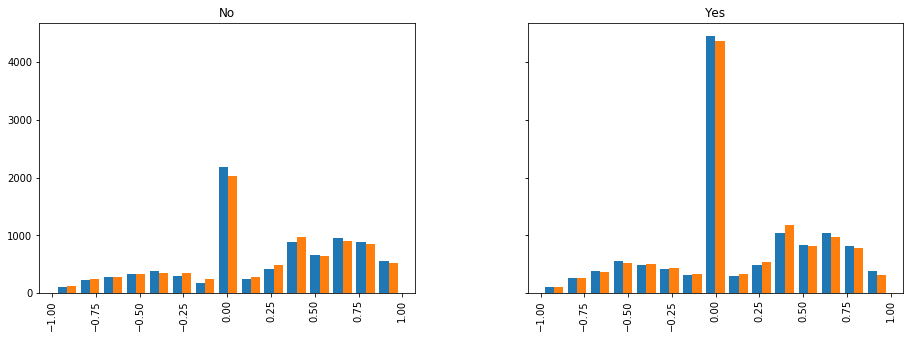

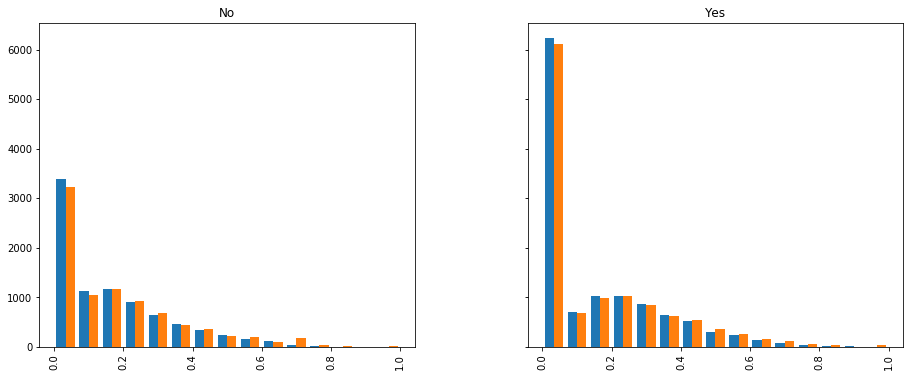

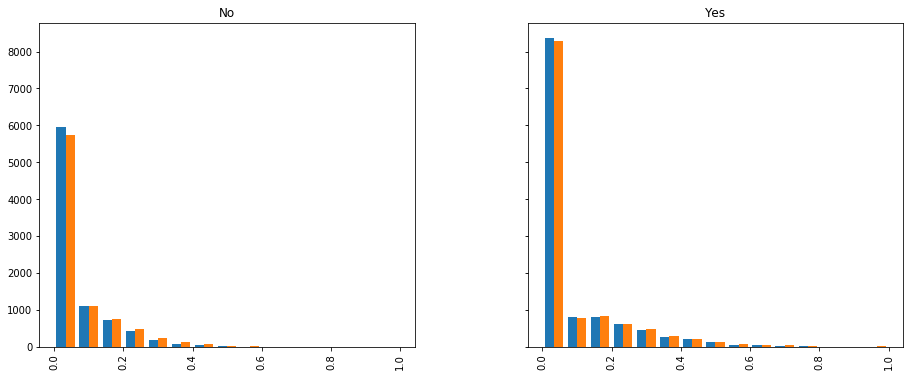

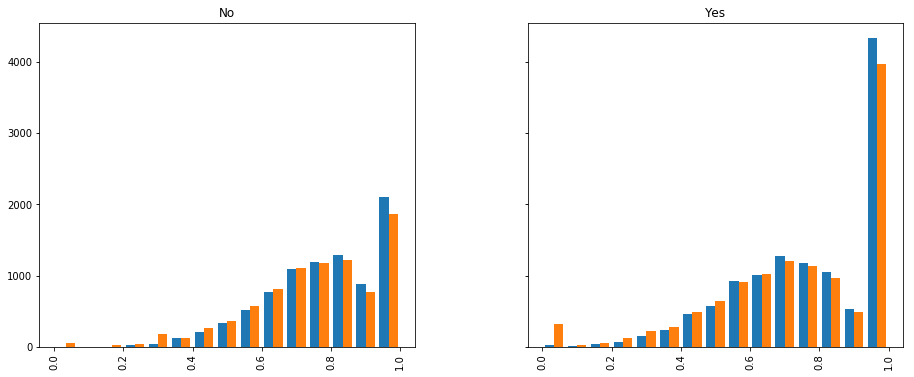

In [79]:
analysed_users[['compound_np','compound']].hist(bins=15, by=analysed_users['is_support'],figsize=(15,5), sharex=True, sharey=True)
analysed_users[['pos_np','pos']].hist(bins=15, by=analysed_users['is_support'], figsize=(15,6), sharex=True, sharey=True)
analysed_users[['neg_np','neg']].hist(bins=15, by=analysed_users['is_support'], figsize=(15,6), sharex=True, sharey=True)
analysed_users[['neu_np','neu']].hist(bins=15, by=analysed_users['is_support'], figsize=(15,6), sharex=True, sharey=True)
